# (70 points) Problem of anomaly detection:
You are given the dataset of network user activity, and the task is to classify each user activity as normal or an attack. 
Attacks are also categorized as follows-
- Denial of Service (dos): Intruder tries to consume server resources as much as possible, so that normal users can’t get resources they need.
- Remote to Local (r2l): Intruder has no legitimate access to victim machine but tries to gain access.
- User to Root (u2r): Intruder has limited privilege access to victim machine but tries to get root privilege.
- Probe: Intruder tries to gain some information about victim machine.

Download dataset from here (http://researchweb.iiit.ac.in/~murtuza.bohra/intrusion_detection.zip).
Dataset contains 29 numerical features and five classes(one normal andfour attacks).

In [24]:
import pandas as pd
import numpy as np
import ipdb

In [25]:
df = pd.read_csv("data/intrusion_detection/data.csv")
df.head(5)
# df.describe()

,duration,service,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,25,193,441,0,0,0,0,0,0,...,255,1.00,0.00,0.07,0.04,0.00,0.04,0.0,0.0,normal
1,0,38,0,0,0,0,0,0,0,0,...,1,0.00,0.07,0.00,0.00,0.00,0.00,1.0,1.0,dos
2,0,25,167,9724,0,0,0,0,0,0,...,255,1.00,0.00,0.03,0.06,0.00,0.00,0.0,0.0,normal
3,0,20,1339,0,0,0,0,0,0,0,...,31,0.23,0.04,0.23,0.00,0.02,0.00,0.0,0.0,normal
4,0,37,0,0,0,0,0,0,0,0,...,25,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.0,dos


# Part-1: (20 points) PCA
Do dimensionality reduction using PCA on given dataset.
- Keep the tolerance of 10% (knee method), meaning reconstruction of the original data from the reduced dimensions in PCA space can be done with 10% error.
- You are only allowed to use eigen decomposition or SVD function from python library(do not use library function to compute PCA directly).

In [26]:
def choose_k(S, percent_variance_to_retain):
    """Chooses least no. of principal components(k) 
    which retains atleast the specified amount of variance in Xapprox."""
    k = 1
    
    while True:
        if np.sum(S[:k]) / np.sum(S) >= (percent_variance_to_retain/100): # :k where k is exclusive 
            return k
        k += 1

def PCA(X):
    """Performs PCA and returns data with reduced dimensions.
    Transform X to Z where dim(X) = mxn and dim(Z) = mxk"""
    mean = X.mean()
    std = X.std()

    # pre processing the data normalize and scale
    X = (X - mean) / std
    
    # compute covariance matrix
    # dim X = m x n
    m = len(X) # no of rows of data
    cov_matrix = (1/m) * np.dot(X.T, X) # nxm X mxn => nxn
    
    U, S, V = np.linalg.svd(cov_matrix)

    k = choose_k(S, 90)
    
    U_reduced = U[:, :k] # pick first k columns for new dimensions
    
    # dim(U_reduced) = nxk
    Z = np.dot(X, U_reduced)  # (m,n) * (n,k) => (m x k)
    return Z

In [27]:
X = df.drop(['xAttack'], axis=1)
print("Original dimensions:", X.shape)

Z = PCA(X)

print("After dimensionality reduction dimensions are:", Z.shape)

Original dimensions: (24998, 29)
After dimensionality reduction dimensions are: (24998, 14)


# Part-2: (15 points) k-means
- Use the reduced dimensions from the first part and perform K-means clustering with k equal to five(number of classes in the data).
- Also calculate the purity of clusters with given class label. Purity is the fraction of actual class samples in that cluster.
- You are not allowed to use inbuilt function for K-means.

In [28]:
# create a dataframe from dimensionally reduced data set
reduced_df=pd.DataFrame(Z)
reduced_df['xAttack'] = df['xAttack']  # FIXME: really slow sometimes RCA?
reduced_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,xAttack
0,-2.509415,-0.952099,-0.080574,0.089473,-0.465558,0.264131,-0.073175,-0.122966,-0.115928,0.037054,-0.015485,0.085030,0.478752,0.380050,normal
1,1.193236,5.598092,-0.270790,1.130941,-0.813088,1.629181,0.541842,0.190282,0.243673,-0.079391,0.028093,0.064366,-0.430109,0.264010,dos
2,-2.447051,-0.908922,-0.060318,0.031070,-0.822722,0.170780,-0.098459,-0.161764,-0.088158,-0.084797,0.005994,0.050481,0.754346,0.429607,normal
3,-1.111736,-0.343088,0.004162,-0.266447,-0.166211,-0.596454,-0.015911,0.026994,0.161910,-0.061835,0.050150,-0.362922,0.542284,0.408395,normal
4,3.983887,-1.268837,-0.050827,0.252373,0.537136,0.561597,0.278500,0.038172,0.012687,-0.004357,-0.013466,0.041690,-0.072666,-0.071331,dos


In [29]:
# convert xAttack column to numerical values
reduced_df.xAttack, mapping_index = pd.Series(reduced_df.xAttack).factorize()
display(reduced_df.head(1))
print(mapping_index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,xAttack
0,-2.509415,-0.952099,-0.080574,0.089473,-0.465558,0.264131,-0.073175,-0.122966,-0.115928,0.037054,-0.015485,0.08503,0.478752,0.38005,0


Index(['normal', 'dos', 'probe', 'r2l', 'u2r'], dtype='object')


In [30]:
class Cluster:
    """Data structure for a cluster."""
    def __init__(self, centroid):
        # centroid of this cluster
        self.centroid = centroid
        
        # points in this cluster
        self.points = np.array([])
        
        
    def update_centroid(self):
        mean = np.mean(self.points, axis=0)
        self.centroid = mean
        
    def add_point(self, point):
        """Adds a point to the cluster."""
        if self.points.size > 0:
            self.points = np.vstack([self.points, point])            
        else:
            self.points = np.array([point])
            # make it a vector
#             self.points = np.reshape(self.points, (1, -1))

            
    def clear(self):
        """Removes all points from the cluster."""
        self.points = np.array([])

    def label(self):
        unique_labels, counts = np.unique(self.points[:,-1], return_counts=True)
        most_prominent_label = unique_labels[np.argmax(counts)]
        
        return most_prominent_label
        
    def purity(self):
        """ A cluster is labelled by the most prominent label in it.
        So purity is the count of most prominent label / total points in the cluster"""
        unique_labels, counts = np.unique(self.points[:, -1], return_counts=True)
        return (100.0 * np.max(counts)) / np.sum(counts)


In [31]:
import random
random.seed(1)

class KMeans:
    def __init__(self, number_of_clusters=5):
        self.K = number_of_clusters
        self.clusters= []
    
    
    def fit(self, X, max_iters):
        X = X.values
        
        # randomly assign k cluster centroids
        # dim(centroids) = k x n
        centroid_indices = random.sample(population=range(len(X)), k=self.K)
        centroids = X[centroid_indices, :]
        
        # Intialize clusters with randomly chosen cluster centroids
        self.clusters = [Cluster(centroid) for centroid in centroids]
        
        it = 0
        
        while True and it < max_iters:
            it += 1
            
            # reset all clusters by removing all points from each
            for cluster in self.clusters:
                cluster.clear()

            # Expectation step: assign points to the nearest cluster center
            for row in X:
                # compute distance of this point from all clusters' centroids
                distances = np.array([self.euclidean_distance(row, cluster.centroid, dims=len(row)-1) for cluster in self.clusters])
                
                # add point to the closest cluster
                self.clusters[np.argmin(distances)].add_point(row)
            
            
            # Maximization step: set the cluster centers to the mean
            for k in range(self.K):
                self.clusters[k].update_centroid()
            
            new_centroids = np.array([cluster.centroid for cluster in self.clusters])
            
            # covergence test
            is_converged = True
            diffs = np.abs(new_centroids - centroids)
            if np.any(diffs > 0):
                is_converged = False
            
            if is_converged:
                break
            
            centroids = new_centroids
            
        print("converged after", it, "iterations")
        

    def euclidean_distance(self, x, y, dims=None):
        if dims is not None:
            x, y = x[:dims], y[:dims]

        return np.sqrt(np.sum((x - y) ** 2)) 


In [32]:
def print_cluster_details(clusters, mapping_index=None):
    for i, cluster in enumerate(clusters):
        label = cluster.label()
        print(f"cluster number: {i}, cluster size: {len(cluster.points)}, cluster purity: {cluster.purity()}, label={mapping_index[int(label)]}({label})")


In [33]:
model = KMeans(number_of_clusters=5)
model.fit(reduced_df, max_iters=300)

converged after 18 iterations


In [34]:
kmeans_clusters = model.clusters
print_cluster_details(kmeans_clusters, mapping_index)

cluster number: 0, cluster size: 13280, cluster purity: 86.15963855421687, label=normal(0.0)
cluster number: 1, cluster size: 4364, cluster purity: 97.70852428964253, label=dos(1.0)
cluster number: 2, cluster size: 2971, cluster purity: 45.91046785594076, label=dos(1.0)
cluster number: 3, cluster size: 1818, cluster purity: 73.7073707370737, label=normal(0.0)
cluster number: 4, cluster size: 2565, cluster purity: 99.22027290448344, label=dos(1.0)


# Part-3 (15 points) GMM
Perform GMM (with five Gaussian) on the reduced dimensions from first part and calculate the purity of clusters. You can use python library for GMM.

In [35]:
from sklearn.mixture import GaussianMixture

X = reduced_df.drop(['xAttack'],axis=1)

gmm = GaussianMixture(n_components=5)
gmm.fit(X)
# labels = gmm.predict(X)

centroids = gmm.means_
gmm_clusters = [Cluster(centroid) for centroid in centroids]

for row in reduced_df.values:
    probs = gmm.predict_proba([row[:-1]])
    gmm_clusters[np.argmax(probs)].add_point(row)
    
    
print_cluster_details(gmm_clusters, mapping_index)

cluster number: 0, cluster size: 2285, cluster purity: 53.69803063457331, label=normal(0.0)
cluster number: 1, cluster size: 6518, cluster purity: 100.0, label=dos(1.0)
cluster number: 2, cluster size: 16186, cluster purity: 74.93512912393426, label=normal(0.0)
cluster number: 3, cluster size: 1, cluster purity: 100.0, label=probe(2.0)
cluster number: 4, cluster size: 8, cluster purity: 100.0, label=normal(0.0)


# Part-4: (15 points) Hierachical clustering
- Perform Hierarchical clustering with single-linkage and fiveclusters. Also calculate the purity of clusters.
- Create a pie chart comparing purity of different clustering methods you have tried for all classes. 
You can use python library for hierarchical clustering.

In [36]:
from sklearn.cluster import AgglomerativeClustering

hcluster = AgglomerativeClustering(n_clusters=5, linkage='single')
hcluster_predict = hcluster.fit_predict(reduced_df.drop(['xAttack'], axis=1))


# create 5 empty clusters
hclusters = [Cluster(x) for x in range(5)]

for cluster_idx, row in zip(hcluster_predict, reduced_df.values):
    hclusters[cluster_idx].add_point(row)
    
print_cluster_details(hclusters, mapping_index)

cluster number: 0, cluster size: 24989, cluster purity: 53.46352395053824, label=normal(0.0)
cluster number: 1, cluster size: 1, cluster purity: 100.0, label=probe(2.0)
cluster number: 2, cluster size: 6, cluster purity: 66.66666666666667, label=r2l(3.0)
cluster number: 3, cluster size: 1, cluster purity: 100.0, label=normal(0.0)
cluster number: 4, cluster size: 1, cluster purity: 100.0, label=normal(0.0)


# Pie chart

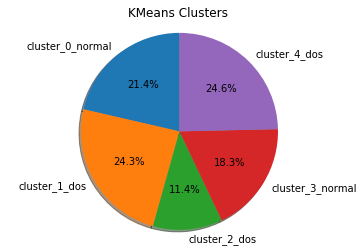

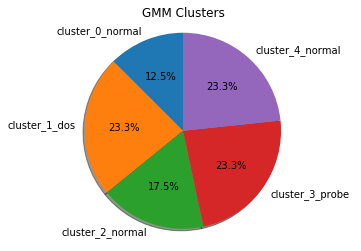

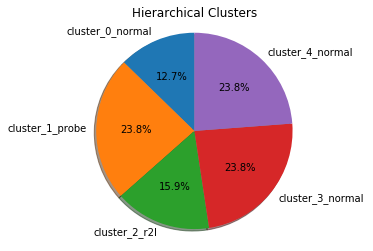

In [38]:
def plot_pie_chart(clusters, title):
    cluster_labels = []
    cluster_sizes = []
    cluster_purities = []
    import matplotlib.pyplot as plt

    for idx, cluster in enumerate(clusters):
        cluster_labels.append(f"cluster_{idx}_{mapping_index[int(cluster.label())]}") 
        cluster_sizes.append(len(cluster.points))
        cluster_purities.append(cluster.purity())


    fig1, ax1 = plt.subplots()
    ax1.pie(cluster_purities, labels=cluster_labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(title)

    plt.show()

plot_pie_chart(kmeans_clusters,"KMeans Clusters")
plot_pie_chart(gmm_clusters,"GMM Clusters")
plot_pie_chart(hclusters,"Hierarchical Clusters")

# Part-5: (5 points) 
Original data of network user activity is available here(https://www.kaggle.com/what0919/intrusion-detection). Original data also contains categorical feature. If you were to do dimensionality reduction on original
data, could you use PCA? Justify. Write a paragraph in report for your explanation/justification.